# Импорт необходимых библиотек

In [352]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score as getAccuracy

import warnings
warnings.filterwarnings("ignore")

# Загрузка и подготовка данных

In [323]:
df = pd.read_csv("data.csv", header = 0)
df.head()

,ID,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Departure.Date,Return.Date,Deposit.Date,Special.Pay,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Early.RPL,Latest.RPL,Cancelled.Pax,Total.Discount.Pax,Initial.System.Date,Poverty.Code,Region,CRM.Segment,School.Type,Parent.Meeting.Flag,MDR.Low.Grade,MDR.High.Grade,Total.School.Enrollment,Income.Level,EZ.Pay.Take.Up.Rate,School.Sponsor,SPR.Product.Type,SPR.New.Existing,FPP,Total.Pax,SPR.Group.Revenue,NumberOfMeetingswithParents,FirstMeeting,LastMeeting,DifferenceTraveltoFirstMeeting,DifferenceTraveltoLastMeeting,SchoolGradeTypeLow,SchoolGradeTypeHigh,SchoolGradeType,DepartureMonth,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.
0,1,HS,4.0,4.0,CA,0,1,A,40557,40557,40420,NaN,424,25,3,0.424,40266.0,40402.0,3,4,40263.0,B,Southern California,4.0,PUBLIC,1,K,5.0,927.0,Q,0.170,1,CA History,EXISTING,59,63,424,1,40402.0,40402.0,155.0,155.0,Elementary,Elementary,Elementary->Elementary,January,K,Elementary,K->Elementary,H,1,0.063646,0.936508,4,L,1
1,2,HC,8.0,8.0,AZ,0,7,A,40557,40564,40132,CP,2350,9,9,0.409,40106.0,40400.0,11,3,40088.0,C,Other,10.0,PUBLIC,1,7,8.0,850.0,A,0.091,0,East Coast,EXISTING,22,25,2350,2,40134.0,40417.0,423.0,140.0,Middle,Middle,Middle->Middle,January,Middle,Middle,Middle->Middle,H,1,0.025882,0.880000,3,L,1
2,3,HD,8.0,8.0,FL,0,3,A,40558,40560,40466,NaN,1181,17,6,0.708,40297.0,40406.0,6,3,40206.0,C,Other,10.0,PUBLIC,1,6,8.0,955.0,O,0.042,0,East Coast,EXISTING,24,27,1181,1,40434.0,40434.0,124.0,124.0,Middle,Middle,Middle->Middle,January,Middle,Middle,Middle->Middle,H,1,0.025131,0.888889,3,L,1
3,4,HN,9.0,12.0,VA,1,3,B,40558,40560,40550,NaN,376,0,0,0.000,NaN,NaN,1,0,40470.0,NaN,Other,7.0,CHD,0,NaN,NaN,NaN,NaN,0.000,0,East Coast,EXISTING,18,18,376,0,NaN,NaN,NaN,NaN,High,High,High->High,January,Undefined,Undefined,Undefined->Undefined,H,0,NaN,1.000000,0,NaN,0
4,5,HD,6.0,8.0,FL,0,6,T,40559,40564,40451,NaN,865,40,8,0.494,40266.0,40402.0,9,8,40260.0,D,Other,10.0,PUBLIC,1,6,8.0,720.0,C,0.383,0,East Coast,EXISTING,81,89,865,1,40414.0,40414.0,145.0,145.0,Middle,Middle,Middle->Middle,January,Middle,Middle,Middle->Middle,H,0,0.112500,0.910112,8,M-L,0


### Устанавливаем соответствующие типы для категориальных данных

In [324]:
df = df.astype({'To.Grade': 'category',
                'Is.Non.Annual.': 'category',
                'From.Grade': 'category',
                'Days' : 'category',
                'NumberOfMeetingswithParents': 'category',
                'SingleGradeTripFlag': 'category',
                'MDR.High.Grade': 'category',
                'Parent.Meeting.Flag': 'category',
                'School.Sponsor': 'category',
                'CRM.Segment': 'category'})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389 entries, 0 to 2388
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              2389 non-null   int64   
 1   Program.Code                    2389 non-null   object  
 2   From.Grade                      2262 non-null   category
 3   To.Grade                        2239 non-null   category
 4   Group.State                     2389 non-null   object  
 5   Is.Non.Annual.                  2389 non-null   category
 6   Days                            2389 non-null   category
 7   Travel.Type                     2389 non-null   object  
 8   Departure.Date                  2389 non-null   int64   
 9   Return.Date                     2389 non-null   int64   
 10  Deposit.Date                    2389 non-null   int64   
 11  Special.Pay                     470 non-null    object  
 12  Tuition             

## Обработка пустых значений

 

In [325]:
pd.DataFrame(df).isna().sum()

ID                                   0
Program.Code                         0
From.Grade                         127
To.Grade                           150
Group.State                          0
Is.Non.Annual.                       0
Days                                 0
Travel.Type                          0
Departure.Date                       0
Return.Date                          0
Deposit.Date                         0
Special.Pay                       1919
Tuition                              0
FRP.Active                           0
FRP.Cancelled                        0
FRP.Take.up.percent.                 0
Early.RPL                          673
Latest.RPL                          19
Cancelled.Pax                        0
Total.Discount.Pax                   0
Initial.System.Date                  8
Poverty.Code                       599
Region                               0
CRM.Segment                          4
School.Type                          0
Parent.Meeting.Flag      

#### Добавляем суррогатные переменные для пропущенных значений

In [326]:
for col in df:
    if df[col].isna().sum() != 0: 
        df[col + '_surrogate'] = df[col].isna().astype(int)

#### Пропущенные категориальные переменные заменяем константой

In [327]:
constImp = SimpleImputer(missing_values = np.nan, strategy='constant')
constImp.fit(df.select_dtypes(exclude=['int64','float64']))
df[df.select_dtypes(exclude=['int64','float64']).columns] = constImp.transform(df.select_dtypes(exclude=['int64','float64']))

#### Пропущенные численные переменные заменяем медианой

In [328]:
medianImp = SimpleImputer(missing_values = np.nan, strategy='median')
medianImp.fit(df.select_dtypes(include=['int64','float64']))
df[df.select_dtypes(include=['int64','float64']).columns] = medianImp.transform(df.select_dtypes(include=['int64','float64']))

In [353]:
pd.DataFrame(df).isna().sum()

ID                                   0
Departure.Date                       0
Return.Date                          0
Deposit.Date                         0
Tuition                              0
                                    ..
SingleGradeTripFlag_1                0
SchoolSizeIndicator_M-L              0
SchoolSizeIndicator_S                0
SchoolSizeIndicator_S-M              0
SchoolSizeIndicator_missing_value    0
Length: 244, dtype: int64

In [330]:
df['Group.State'].value_counts()

CA                718
TX                308
WA                147
IL                104
CO                 89
MI                 71
FL                 62
AZ                 53
OH                 53
MN                 51
OR                 51
WI                 46
IN                 43
MO                 43
NE                 42
TN                 38
MA                 36
IA                 35
OK                 33
LA                 31
KS                 26
GA                 22
AL                 21
NV                 20
NM                 20
NY                 19
VA                 18
KY                 16
NC                 16
MD                 15
CT                 15
ID                 14
SD                 11
AR                 10
SC                 10
HI                  9
MS                  9
UT                  9
ME                  7
NH                  7
MT                  6
NJ                  6
AK                  5
PA                  5
ND                  5
RI        

## Объединяем редкие(до 10) текстовые значения

In [331]:
table = df
for col in table.columns:
    if table[col].dtype == 'object':
      for index, row in pd.DataFrame(table[col].value_counts()).iterrows():
          if ( row[0] < 10):
              df[col].replace(index, f'other{col}', inplace = True)
              
df[0:10]

,ID,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Departure.Date,Return.Date,Deposit.Date,Special.Pay,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Early.RPL,Latest.RPL,Cancelled.Pax,Total.Discount.Pax,Initial.System.Date,Poverty.Code,Region,CRM.Segment,School.Type,Parent.Meeting.Flag,MDR.Low.Grade,MDR.High.Grade,Total.School.Enrollment,Income.Level,EZ.Pay.Take.Up.Rate,School.Sponsor,SPR.Product.Type,SPR.New.Existing,FPP,Total.Pax,SPR.Group.Revenue,NumberOfMeetingswithParents,FirstMeeting,LastMeeting,DifferenceTraveltoFirstMeeting,DifferenceTraveltoLastMeeting,SchoolGradeTypeLow,SchoolGradeTypeHigh,SchoolGradeType,DepartureMonth,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.,From.Grade_surrogate,To.Grade_surrogate,Special.Pay_surrogate,Early.RPL_surrogate,Latest.RPL_surrogate,Initial.System.Date_surrogate,Poverty.Code_surrogate,CRM.Segment_surrogate,MDR.Low.Grade_surrogate,MDR.High.Grade_surrogate,Total.School.Enrollment_surrogate,Income.Level_surrogate,FirstMeeting_surrogate,LastMeeting_surrogate,DifferenceTraveltoFirstMeeting_surrogate,DifferenceTraveltoLastMeeting_surrogate,FPP.to.School.enrollment_surrogate,SchoolSizeIndicator_surrogate
0,1.0,HS,4.0,4.0,CA,0,1,A,40557.0,40557.0,40420.0,missing_value,424.0,25.0,3.0,0.424,40266.0,40402.0,3.0,4.0,40263.0,B,Southern California,4.0,PUBLIC,1,K,5.0,927.0,Q,0.170,1,CA History,EXISTING,59.0,63.0,424.0,1,40402.0,40402.0,155.0,155.0,Elementary,Elementary,Elementary->Elementary,otherDepartureMonth,K,Elementary,K->Elementary,H,1,0.063646,0.936508,4.0,L,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,HC,8.0,8.0,AZ,0,7,A,40557.0,40564.0,40132.0,CP,2350.0,9.0,9.0,0.409,40106.0,40400.0,11.0,3.0,40088.0,C,Other,10.0,PUBLIC,1,7,8.0,850.0,A,0.091,0,East Coast,EXISTING,22.0,25.0,2350.0,2,40134.0,40417.0,423.0,140.0,Middle,Middle,Middle->Middle,otherDepartureMonth,Middle,Middle,Middle->Middle,H,1,0.025882,0.880000,3.0,L,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,HD,8.0,8.0,FL,0,3,A,40558.0,40560.0,40466.0,missing_value,1181.0,17.0,6.0,0.708,40297.0,40406.0,6.0,3.0,40206.0,C,Other,10.0,PUBLIC,1,6,8.0,955.0,O,0.042,0,East Coast,EXISTING,24.0,27.0,1181.0,1,40434.0,40434.0,124.0,124.0,Middle,Middle,Middle->Middle,otherDepartureMonth,Middle,Middle,Middle->Middle,H,1,0.025131,0.888889,3.0,L,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,HN,9.0,12.0,VA,1,3,B,40558.0,40560.0,40550.0,missing_value,376.0,0.0,0.0,0.000,40262.0,40417.0,1.0,0.0,40470.0,missing_value,Other,7.0,CHD,0,missing_value,missing_value,597.0,missing_value,0.000,0,East Coast,EXISTING,18.0,18.0,376.0,0,40435.0,40442.0,250.0,233.0,High,High,High->High,otherDepartureMonth,Undefined,Undefined,Undefined->Undefined,H,0,0.045256,1.000000,0.0,missing_value,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,5.0,HD,6.0,8.0,FL,0,6,otherTravel.Type,40559.0,40564.0,40451.0,missing_value,865.0,40.0,8.0,0.494,40266.0,40402.0,9.0,8.0,40260.0,D,Other,10.0,PUBLIC,1,6,8.0,720.0,C,0.383,0,East Coast,EXISTING,81.0,89.0,865.0,1,40414.0,40414.0,145.0,145.0,Middle,Middle,Middle->Middle,otherDepartureMonth,Middle,Middle,Middle->Middle,H,0,0.112500,0.910112,8.0,M-L,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6.0,HC,10.0,12.0,LA,0,4,A,40560.0,40563.0,40451.0,missing_value,2025.0,9.0,4.0,0.900,40253.0,40457.0,3.0,1.0,40253.0,C,Other,8.0,PUBLIC,1,otherMDR.Low.Grade,12.0,939.0,I,0.100,0,East Coast,NEW,10.0,11.0,2025.0,1,40469.0,40469.0,91.0,91.0,High,High,High->High,otherDepartureMonth,High,High,High->High,H,0,0.010650,0.909091,1.0,L,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7.0,SG,11.0,12.0,MA,1,6,A,40561.0,40566.0,40466.0,missing_value,1977.0,16.0,4.0,0.640,40234.0,40422.0,5.0,2.0,40234.0,m

## Создаем дамми переменные

In [332]:
df = pd.get_dummies(df, columns = df.select_dtypes(exclude=['int64','float64']).columns, drop_first = True)
df.head()

,ID,Departure.Date,Return.Date,Deposit.Date,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Early.RPL,Latest.RPL,Cancelled.Pax,Total.Discount.Pax,Initial.System.Date,Total.School.Enrollment,EZ.Pay.Take.Up.Rate,FPP,Total.Pax,SPR.Group.Revenue,FirstMeeting,LastMeeting,DifferenceTraveltoFirstMeeting,DifferenceTraveltoLastMeeting,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,Retained.in.2012.,From.Grade_surrogate,To.Grade_surrogate,Special.Pay_surrogate,Early.RPL_surrogate,Latest.RPL_surrogate,Initial.System.Date_surrogate,Poverty.Code_surrogate,CRM.Segment_surrogate,MDR.Low.Grade_surrogate,MDR.High.Grade_surrogate,Total.School.Enrollment_surrogate,Income.Level_surrogate,FirstMeeting_surrogate,LastMeeting_surrogate,DifferenceTraveltoFirstMeeting_surrogate,DifferenceTraveltoLastMeeting_surrogate,FPP.to.School.enrollment_surrogate,SchoolSizeIndicator_surrogate,Program.Code_CD,Program.Code_HC,Program.Code_HD,Program.Code_HG,Program.Code_HN,Program.Code_HO,Program.Code_HS,Program.Code_HVP,Program.Code_IC,Program.Code_SC,Program.Code_SG,Program.Code_SK,Program.Code_SM,Program.Code_ST,Program.Code_otherProgram.Code,From.Grade_5.0,From.Grade_6.0,From.Grade_7.0,From.Grade_8.0,From.Grade_9.0,From.Grade_10.0,From.Grade_11.0,From.Grade_12.0,From.Grade_missing_value,From.Grade_otherFrom.Grade,To.Grade_5.0,To.Grade_6.0,To.Grade_7.0,To.Grade_8.0,To.Grade_9.0,To.Grade_10.0,To.Grade_11.0,To.Grade_12.0,To.Grade_missing_value,To.Grade_otherTo.Grade,Group.State_AR,Group.State_AZ,Group.State_CA,Group.State_CO,Group.State_CT,Group.State_FL,Group.State_GA,Group.State_IA,Group.State_ID,Group.State_IL,Group.State_IN,Group.State_KS,Group.State_KY,Group.State_LA,Group.State_MA,Group.State_MD,Group.State_MI,Group.State_MN,Group.State_MO,Group.State_NC,Group.State_NE,Group.State_NM,Group.State_NV,Group.State_NY,Group.State_OH,Group.State_OK,Group.State_OR,Group.State_SC,Group.State_SD,Group.State_TN,Group.State_TX,Group.State_VA,Group.State_WA,Group.State_WI,Group.State_otherGroup.State,Is.Non.Annual._1,Days_2,Days_3,Days_4,Days_5,Days_6,Days_7,Days_8,Days_11,Days_otherDays,Travel.Type_B,Travel.Type_otherTravel.Type,Special.Pay_FR,Special.Pay_SA,Special.Pay_missing_value,Poverty.Code_B,Poverty.Code_C,Poverty.Code_D,Poverty.Code_E,Poverty.Code_missing_value,Poverty.Code_otherPoverty.Code,Region_Houston,Region_Northern California,Region_Other,Region_Pacific Northwest,Region_Southern California,CRM.Segment_2.0,CRM.Segment_3.0,CRM.Segment_4.0,CRM.Segment_5.0,CRM.Segment_6.0,CRM.Segment_7.0,CRM.Segment_8.0,CRM.Segment_10.0,CRM.Segment_11.0,CRM.Segment_otherCRM.Segment,School.Type_Catholic,School.Type_PUBLIC,School.Type_Private non-Christian,Parent.Meeting.Flag_1,MDR.Low.Grade_4,MDR.Low.Grade_5,MDR.Low.Grade_6,MDR.Low.Grade_7,MDR.Low.Grade_8,MDR.Low.Grade_9,MDR.Low.Grade_K,MDR.Low.Grade_PK,MDR.Low.Grade_missing_value,MDR.Low.Grade_otherMDR.Low.Grade,MDR.High.Grade_6.0,MDR.High.Grade_7.0,MDR.High.Grade_8.0,MDR.High.Grade_9.0,MDR.High.Grade_12.0,MDR.High.Grade_missing_value,MDR.High.Grade_otherMDR.High.Grade,Income.Level_B,Income.Level_C,Income.Level_D,Income.Level_E,Income.Level_F,Income.Level_G,Income.Level_H,Income.Level_I,Income.Level_J,Income.Level_K,Income.Level_L,Income.Level_M,Income.Level_N,Income.Level_O,Income.Level_P,Income.Level_Q,Income.Level_Z,Income.Level_missing_value,Income.Level_otherIncome.Level,School.Sponsor_1,SPR.Product.Type_Costa Rica,SPR.Product.Type_East Coast,SPR.Product.Type_International,SPR.Product.Type_Science,SPR.Product.Type_otherSPR.Product.Type,SPR.New.Existing_NEW,NumberOfMeetingswithParents_1,NumberOfMeetingswithParents_2,SchoolGradeTypeLow_High,SchoolGradeTypeLow_Middle,SchoolGradeTypeLow_Undefined,SchoolGradeTypeHigh_High,SchoolGradeTypeHigh_Middle,SchoolGradeTypeHigh_Undefined,SchoolGradeType_Elementary->Middle,SchoolGradeType_High->High,SchoolGradeType_Middle->High,SchoolGradeType_Middle->Middle,SchoolGradeType_Middle->Undefined,SchoolGradeType_Undefined->Undefined,SchoolGradeType_otherSchoolGradeType,Departur

# Определяем зависимую и независымые переменные

In [333]:
y = df['Retained.in.2012.']
X = df.drop(columns = 'Retained.in.2012.')

# Разделяем на тестовую и обучающую выборки

In [334]:
np.random.seed(77300)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1791, 243)
(598, 243)
(1791,)
(598,)


# Методы для оценки моделей

In [335]:
def plotRoc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='pink', label=f'Кривая ROC AUC:{roc_auc}')
    plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
    plt.xlabel('Ложно отрицательный процент')
    plt.ylabel('Истино положительный процент')
    plt.title('Кривая ROC')
    plt.show()


def getPpv(y_test, y_pred):
    tp = sum((y_test == 1) & (y_pred == 1))
    fp = sum((y_test == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) != 0 else 0.0


def getNpv(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn / (tn + fn)


# Логистическая регрессия

In [336]:
# обучаем модель
LrModel = LogisticRegression()
LrModel.fit(X_train, y_train)

# Коэффициенты переменных 
summary = pd.DataFrame({'Переменная': X_test.columns, 'Коэффициент': LrModel.coef_[0]})
summary = summary.sort_values(by='Коэффициент', ascending=False)
top10positive = summary.head(10)
top10negative = summary.tail(10)
top10list = pd.concat([top10positive, top10negative])
top10list


,Переменная,Коэффициент
16,Total.Pax,0.009765
15,FPP,0.008976
9,Latest.RPL,0.005163
5,FRP.Active,0.005156
8,Early.RPL,0.003177
18,FirstMeeting,0.000823
24,Num.of.Non_FPP.PAX,0.000789
11,Total.Discount.Pax,0.000789
21,DifferenceTraveltoLastMeeting,0.000516
238,SingleGradeTripFlag_1,0.000423


In [337]:
# получаем предсказания модели для тестовой выборки
y_pred_prob = LrModel.predict_proba(X_test)[:,1] # вероятности

# Критическое (пороговое) значение -- будем использовать Т=0.6073. Почему? Почему не 50%? 60,73% -- это средняя вероятность удержания клиента в наших данных (1451 "1" из 2389 наблюдений) 
class_threshold = 0.6073

y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # классификация

print(y_pred_prob[0:5]) # распечатаем полученные вероятности (первые 5)
print(y_pred[0:5]) # распечатаем полученную классификацию (первые 5)
print(y_test[0:5]) # распечатаем реальные исходы (первые 5)


[0.45558786 0.78495445 0.85308785 0.57253326 0.36723295]
[0 1 1 0 0]
2047    0.0
746     1.0
1103    1.0
1838    0.0
1990    0.0
Name: Retained.in.2012., dtype: float64


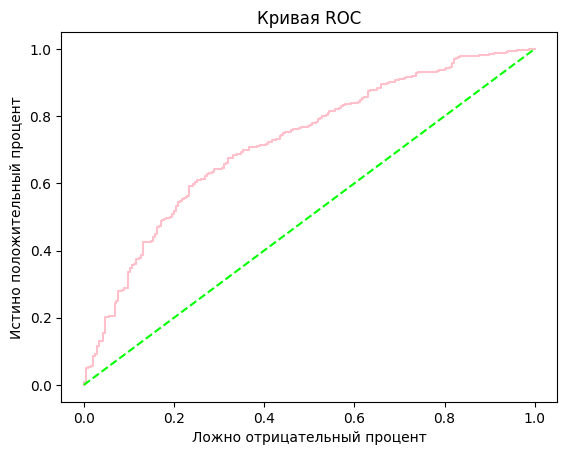

Точность: 0.6655518394648829
AUC: 0.721411406130942
PPV: 0.7800687285223368
NPV: 0.5570032573289903


In [338]:
plotRoc(y_test, y_pred_prob)
print("Точность: " + str(getAccuracy(y_test, y_pred)))
print("AUC: " + str(roc_auc_score(y_test, y_pred_prob)))
print("PPV: " + str(getPpv(y_test, y_pred)))
print("NPV: " + str(getNpv(y_test, y_pred)))

# Деревья классификации и регрессии


In [339]:
# обучаем модель
dtModel = DecisionTreeClassifier(max_leaf_nodes = 7, random_state=77300)
dtModel.fit(X_train, y_train)

# получаем предсказания модели для тестовой выборки
y_pred_prob = dtModel.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

print(y_pred_prob[0:5]) #  полученные вероятности (первые 5)
print(y_pred[0:5]) #  полученную классификацию (первые 5)
print(y_test[0:5]) #  реальные исходы (первые 5)

[0.25632911 0.88601036 0.88601036 0.88601036 0.25632911]
[0 1 1 1 0]
2047    0.0
746     1.0
1103    1.0
1838    0.0
1990    0.0
Name: Retained.in.2012., dtype: float64


[Text(0.5454545454545454, 0.9, 'SingleGradeTripFlag_1 <= 0.5\ngini = 0.477\nsamples = 1791\nvalue = [703, 1088]\nclass = Удержан'),
 Text(0.36363636363636365, 0.7, 'Is.Non.Annual._1 <= 0.5\ngini = 0.462\nsamples = 799\nvalue = [510, 289]\nclass = Не удержан'),
 Text(0.2727272727272727, 0.5, 'SPR.New.Existing_NEW <= 0.5\ngini = 0.494\nsamples = 562\nvalue = [312, 250]\nclass = Не удержан'),
 Text(0.18181818181818182, 0.3, 'Total.Pax <= 22.5\ngini = 0.43\nsamples = 246\nvalue = [77, 169]\nclass = Удержан'),
 Text(0.09090909090909091, 0.1, 'gini = 0.491\nsamples = 138\nvalue = [60, 78]\nclass = Удержан'),
 Text(0.2727272727272727, 0.1, 'gini = 0.265\nsamples = 108\nvalue = [17, 91]\nclass = Удержан'),
 Text(0.36363636363636365, 0.3, 'gini = 0.381\nsamples = 316\nvalue = [235, 81]\nclass = Не удержан'),
 Text(0.45454545454545453, 0.5, 'gini = 0.275\nsamples = 237\nvalue = [198, 39]\nclass = Не удержан'),
 Text(0.7272727272727273, 0.7, 'FPP <= 13.5\ngini = 0.313\nsamples = 992\nvalue = [193

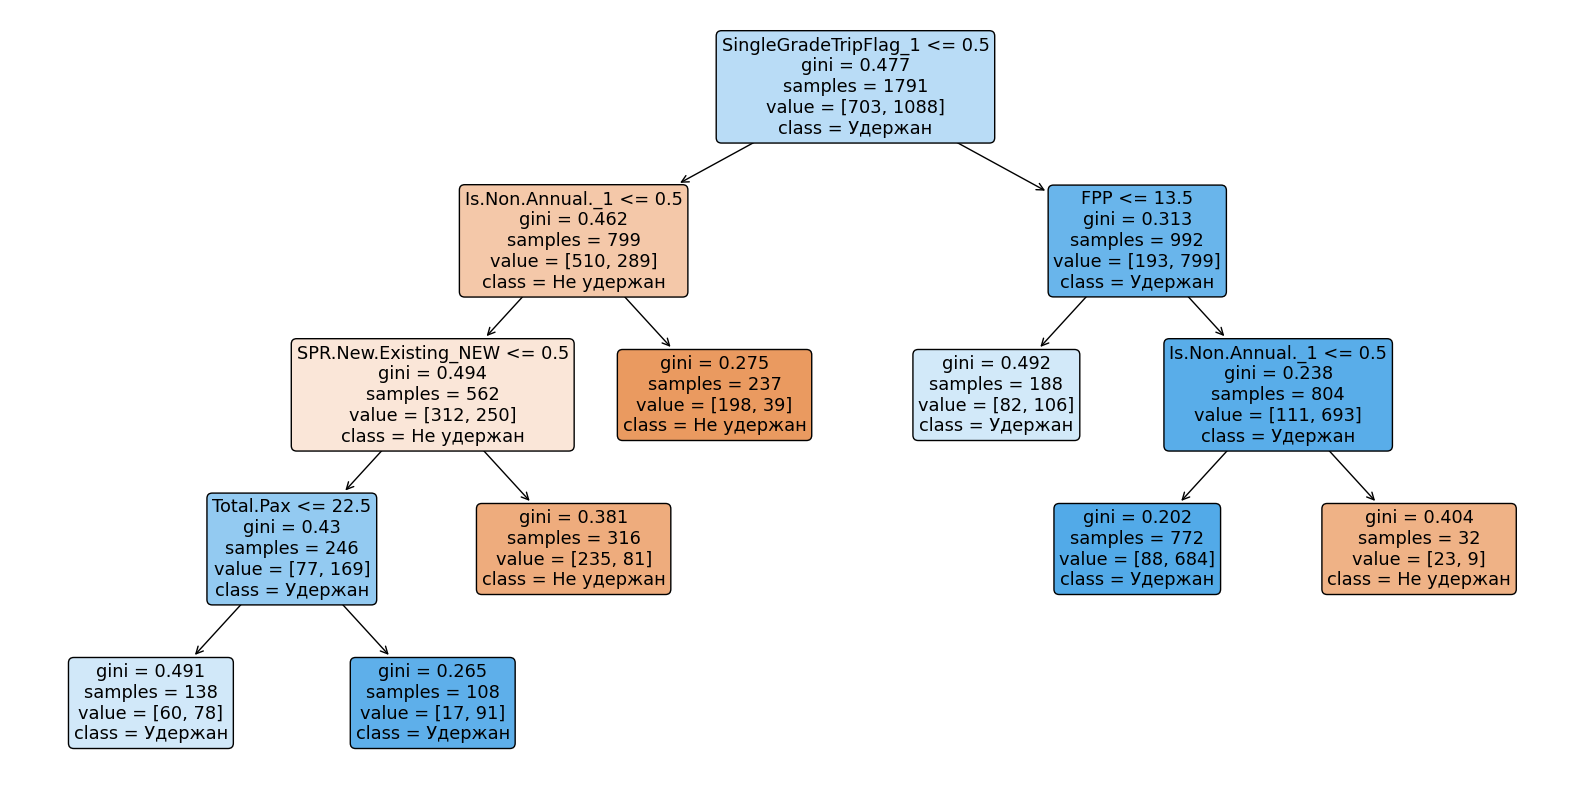

In [340]:
from sklearn import tree

plt.figure(figsize=(20,10))
tree.plot_tree(dtModel.fit(X_train, y_train), feature_names = X_train.columns, filled = True, 
               class_names = ['Не удержан', 'Удержан'], rounded = True)


Метрики модели: 



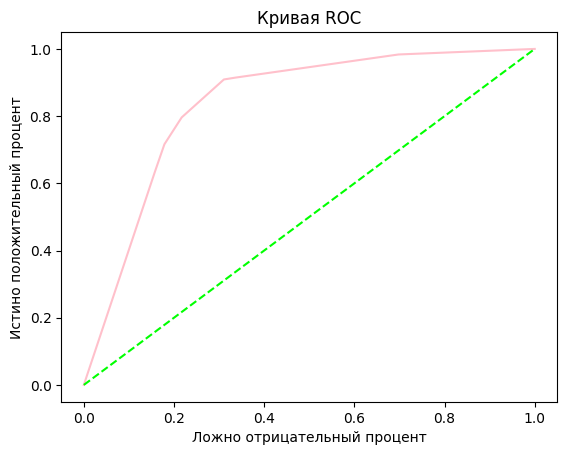

Точность: 0.7575250836120402
AUC: 0.8392005157962605
PPV: 0.8609271523178808
NPV: 0.652027027027027


In [341]:
print('Метрики модели: \n')

plotRoc(y_test, y_pred_prob)
print("Точность: " + str(getAccuracy(y_test, y_pred))) 
print("AUC: " + str(roc_auc_score(y_test, y_pred_prob)))
print("PPV: " + str(getPpv(y_test, y_pred)))
print("NPV: " + str(getNpv(y_test, y_pred)))

## Итог для модели деревьев решений: 

- обучили модель с "базовыми" (встроеными) гипер-параметрами
- применили к тестовой выборке, AUC=80,0%
- провели подбор гипер-параметра "максимальное число листьев," AUC  выросла до 83,8%

# Случайный лес

In [342]:
# обучаем модель
rfModel = RandomForestClassifier(random_state=77300)
rfModel.fit(X_train, y_train)



RandomForestClassifier(random_state=77300)

In [343]:
# получаем предсказания модели для тестовой выборки
y_pred_prob = rfModel.predict_proba(X_test)[:,1] # вероятности 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # классификация

Метрики модели: 



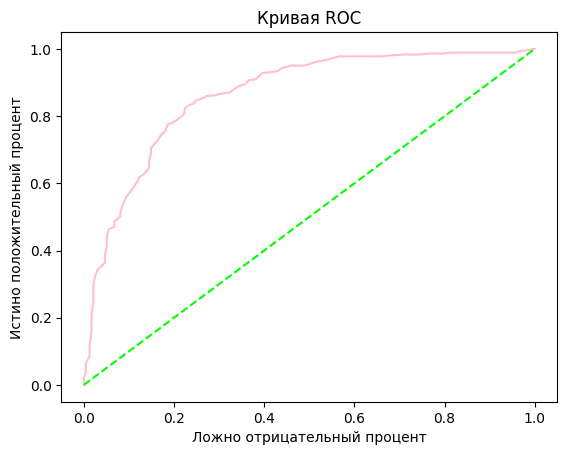

Точность: 0.7775919732441472
AUC: 0.8644452259539301
PPV: 0.8709677419354839
NPV: 0.6770833333333334


In [344]:
# метрики модели
print('Метрики модели: \n')

plotRoc(y_test, y_pred_prob)
print("Точность: " + str(getAccuracy(y_test, y_pred))) 
print("AUC: " + str(roc_auc_score(y_test, y_pred_prob)))
print("PPV: " + str(getPpv(y_test, y_pred)))
print("NPV: " + str(getNpv(y_test, y_pred)))

<Axes: title={'center': 'Важность переменных'}>

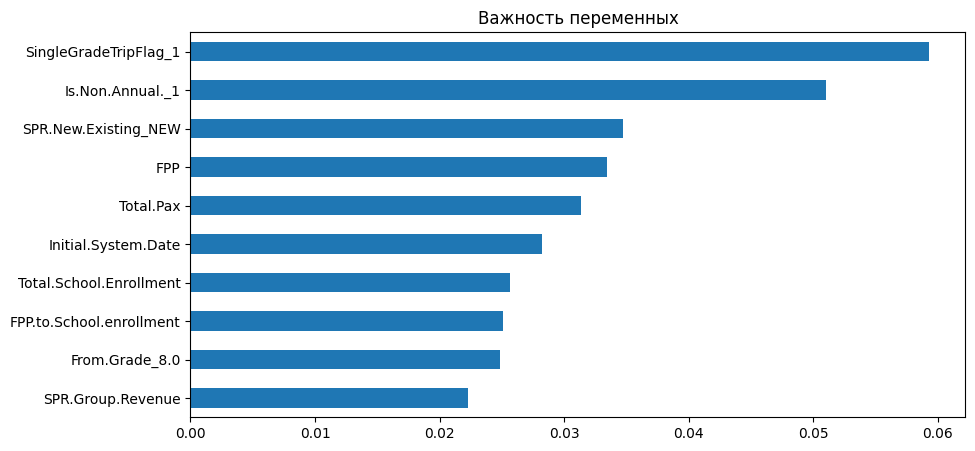

In [345]:
importances = rfModel.feature_importances_ 

plt.figure(figsize=(10,5))
plt.title('Важность переменных')
plt.xlabel('Относительная важность')

feature_importances = pd.Series(rfModel.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).sort_values().plot(kind='barh')

# Градиентный бустинг

In [346]:
#обучаем модель
gbModel = GradientBoostingClassifier(random_state=77300)
gbModel.fit(X_train, y_train)


GradientBoostingClassifier(random_state=77300)

In [347]:
y_pred_prob = gbModel.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

Метрики модели: 



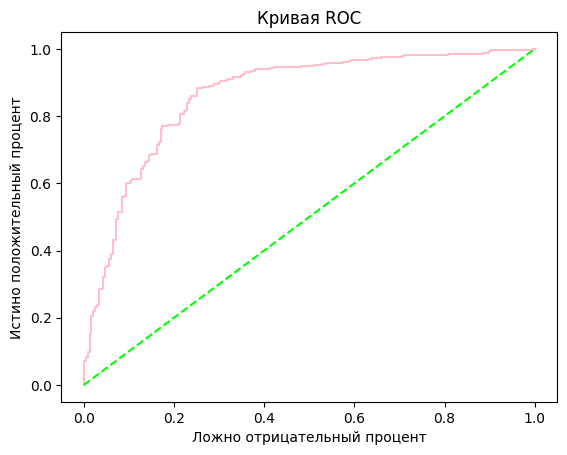

Точность: 0.7993311036789298
AUC: 0.8646620948361761
PPV: 0.8501440922190202
NPV: 0.7290836653386454


In [348]:
print('Метрики модели: \n')

plotRoc(y_test, y_pred_prob)
print("Точность: " + str(getAccuracy(y_test, y_pred))) 
print("AUC: " + str(roc_auc_score(y_test, y_pred_prob)))
print("PPV: " + str(getPpv(y_test, y_pred)))
print("NPV: " + str(getNpv(y_test, y_pred)))

# Экспорт

In [350]:
y_pred_prob = rfModel.predict_proba(X_test)[:,1]   

Prediction = pd.DataFrame(data={"ID":X_test["ID"],"Predicted Probability":y_pred_prob}) 
Prediction.to_csv("predictedRfModel.csv",sep = ',')